In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import seaborn as sns

/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# df = pd.read_parquet("/Users/sawale/Documents/FunnyProject/data/labeled_jokes.parquet")
TARGET_COLUMNS = ['humor', 'offensiveness', 'sentiment']
def load_data(file_path, nrows=None):
    # Load dataset from a Parquet file
    df = pd.read_parquet(file_path)
    if nrows:
        df = df.head(nrows)
    
    # Cast the target columns to int for classification purposes.
    df[TARGET_COLUMNS] = df[TARGET_COLUMNS].astype(int)
    
    # Drop rows where any value in the target columns isn't 0 or 1.
    # This creates a boolean mask that checks for binary values.
    df = df[df[TARGET_COLUMNS].isin([0, 1]).all(axis=1)]
    
    # Ensure that the 'joke' column is of type string.
    df['joke'] = df['joke'].astype(str)

    
    return df

df = load_data("../data/labeled_jokes_classification_mistral:latest.parquet")
df.shape

(57296, 6)

In [4]:
df.head()

,date,joke,score,humor,offensiveness,sentiment
408620,2018-08-12 19:23:12,Have you heard the Asian cover to “Come on Eil...,2.0,0,1,0
226969,2016-11-24 06:24:39,We're celebrating Thanksgiving the old fashion...,3.0,0,1,0
212615,2016-10-09 23:28:56,How do you tell a bad joke from a good joke? Y...,1.0,1,0,1
392576,2018-06-16 15:34:47,What do you call a baby Bible? A Biblet,0.0,1,0,1
65069,2014-12-16 21:06:58,Asians be like... ay bb u wan sum duck?,0.0,0,1,0


In [5]:
# shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df[df["offensiveness"] == 1]

,date,joke,score,humor,offensiveness,sentiment
11,2017-07-25 20:18:45,Why did the pervert cross the road? nsfw Becau...,0.0,0,1,0
13,2016-09-30 17:49:51,"Today I found out that you are what you eat, I...",1.0,0,1,0
17,2016-11-10 19:35:45,How many feminists does it take to change a li...,0.0,0,1,0
20,2016-04-28 19:31:58,"A Strange Date A young man, out on the tiles w...",177.0,1,1,0
23,2018-02-20 06:33:41,Old woman in her 60s “An old woman in her 60’s...,3.0,0,1,0
...,...,...,...,...,...,...
57265,2016-11-18 18:35:43,What's the best part about having sex with a 6...,0.0,0,1,0
57267,2018-03-29 17:04:27,"What word begins with M, ends in arriage, and ...",0.0,0,1,0
57273,2019-01-28 11:59:18,Why did Hitler kill himself? He got the Gas-...,3.0,0,1,0
57279,2017-03-14 17:59:27,These hard working muslims always trying to ge...,1.0,0,1,0


# EDA on joke length

Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


Five-Point Summary for Joke Token Counts:
min: 2
Q1: 17.0
median: 24.0
Q3: 45.0
max: 2845
Percentage of documents with token counts > 128: 12.31%
Token count at 99.9th percentile: 883.1150000000271


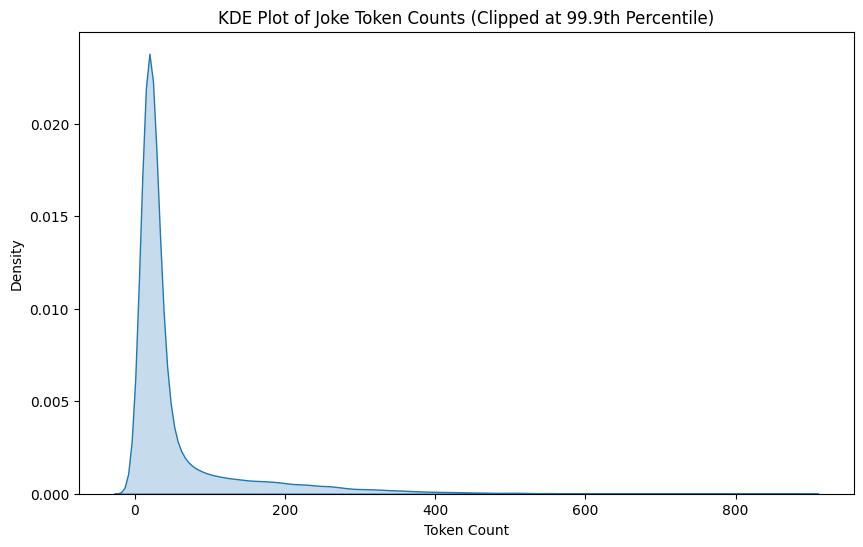

In [7]:
# Step 1: Initialize the tokenizer from Hugging Face.
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base")

# Step 2: Create a new column to count the tokens in each joke.
# Here, tokenizer.tokenize(x) returns a list of tokens, and we take its length.
df['joke_token_count'] = df['joke'].apply(lambda x: len(tokenizer.tokenize(x)))

# Step 3: Compute the five-number summary for token counts.
five_point_summary = {
    'min': df['joke_token_count'].min(),
    'Q1': df['joke_token_count'].quantile(0.25),
    'median': df['joke_token_count'].median(),
    'Q3': df['joke_token_count'].quantile(0.75),
    'max': df['joke_token_count'].max()
}

print("Five-Point Summary for Joke Token Counts:")
for key, value in five_point_summary.items():
    print(f"{key}: {value}")

# Step 4: Calculate the percentage of documents with token count greater than 512.
docs_over_512 = (df['joke_token_count'] > 128).sum()
total_docs = len(df)
percentage_over_512 = (docs_over_512 / total_docs) * 100
print(f"Percentage of documents with token counts > 128: {percentage_over_512:.2f}%")

# Step 5: Determine the clip value: the 99.9th percentile of the token counts.
clip_value = df['joke_token_count'].quantile(0.999)
print(f"Token count at 99.9th percentile: {clip_value}")

# Step 6: Plot the KDE (Kernel Density Estimate) of the token count distribution.
# We filter the data to include only those documents with token counts less than or equal to clip_value.
plt.figure(figsize=(10, 6))
filtered_data = df[df['joke_token_count'] <= clip_value]
sns.kdeplot(data=filtered_data, x='joke_token_count', fill=True)
plt.title("KDE Plot of Joke Token Counts (Clipped at 99.9th Percentile)")
plt.xlabel("Token Count")
plt.ylabel("Density")
plt.show()

# Analysis on target columns

Distribution for humor:
       Count  Percentage (%)
humor                       
0      18820           32.85
1      38476           67.15


Distribution for offensiveness:
               Count  Percentage (%)
offensiveness                       
0              47096            82.2
1              10200            17.8


Distribution for sentiment:
           Count  Percentage (%)
sentiment                       
0          20936           36.54
1          36360           63.46




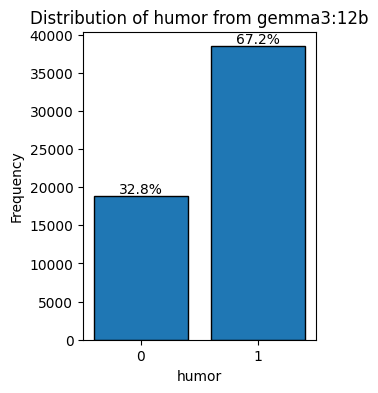

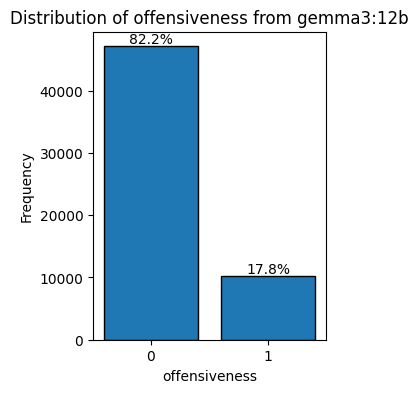

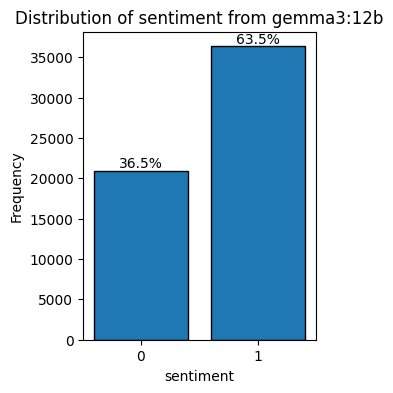

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is already loaded as 'df'
discrete_cols = ['humor', 'offensiveness', 'sentiment']

# 1. For each discrete column, print frequency counts and percentages.
for col in discrete_cols:
    print(f"Distribution for {col}:")
    counts = df[col].value_counts().sort_index()
    percentages = (counts / counts.sum() * 100).round(2)
    summary_df = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages})
    print(summary_df)
    print("\n")

# 2. Plot the distribution for each discrete column using bar charts.
for col in discrete_cols:
    counts = df[col].value_counts().sort_index()
    plt.figure(figsize=(3, 4))
    plt.bar(counts.index.astype(str), counts.values, edgecolor='black')
    plt.title(f"Distribution of {col} from gemma3:12b")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    # Optionally, add the percentage on top of each bar for clarity.
    for index, value in counts.items():
        plt.text(x=str(index), y=value, s=f"{(value / counts.sum() * 100):.1f}%", ha='center', va='bottom')
    plt.show()


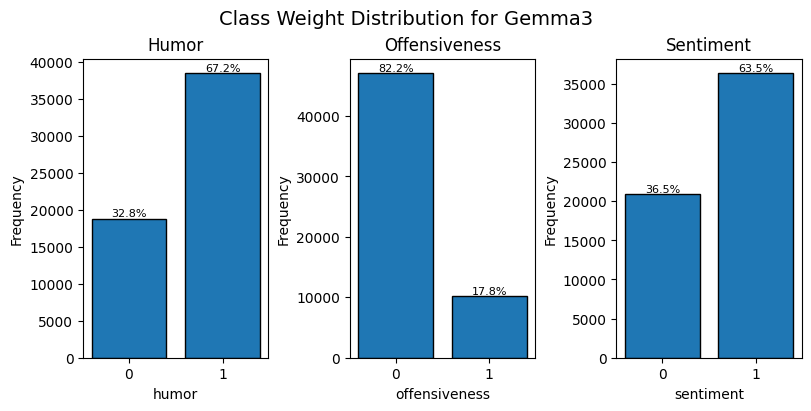

In [9]:
import matplotlib.pyplot as plt

# Assume `df` contains only the data for the one model you’re plotting
metrics = ['humor', 'offensiveness', 'sentiment']

fig, axes = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True)

for ax, metric in zip(axes, metrics):
    counts = df[metric].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values, edgecolor='black')
    ax.set_title(metric.capitalize())
    ax.set_xlabel(metric)
    ax.set_ylabel('Frequency')
    # annotate percentage on each bar
    total = counts.sum()
    for i, v in enumerate(counts.values):
        ax.text(i, v, f"{v/total*100:.1f}%", ha='center', va='bottom', fontsize=8)

fig.suptitle('Class Weight Distribution for Gemma3', fontsize=14)
plt.show()


# Chroma Analysis

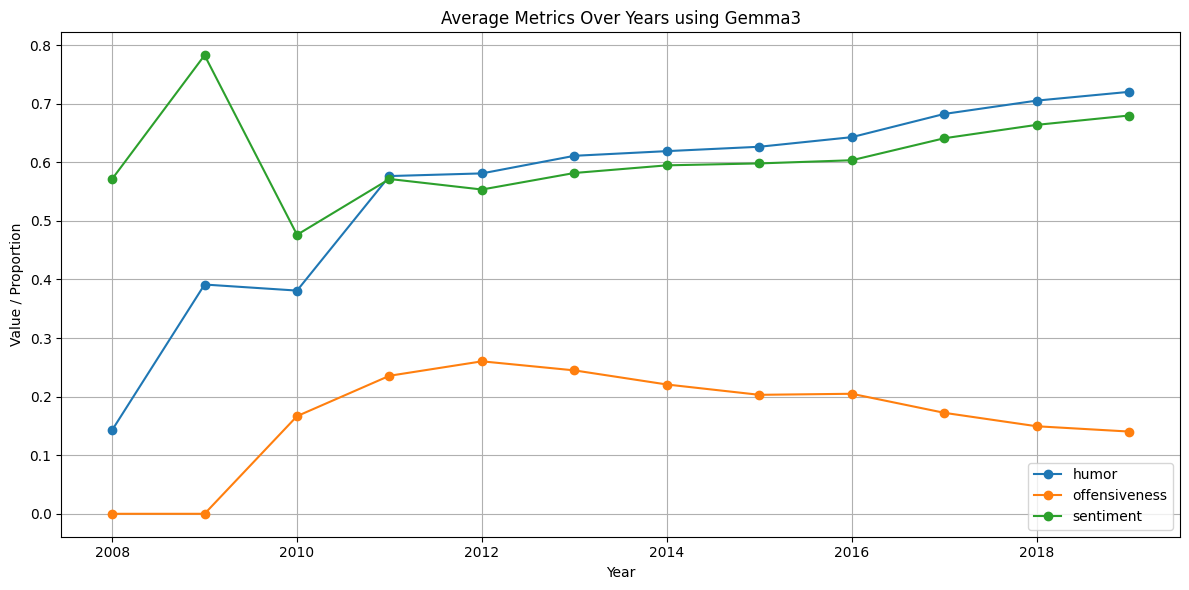

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that the 'date' column is in datetime format and extract the year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# ----- 1. Continuous Metrics: Humor and Offensiveness -----
continuous_cols = ['humor', 'offensiveness', 'sentiment']
yearly_avg = df.groupby('year')[continuous_cols].mean()

# ----- Combined Plot on a Single y-axis -----
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the continuous metrics
for metric in continuous_cols:
    ax.plot(yearly_avg.index, yearly_avg[metric], marker='o', label=metric)

ax.set_xlabel('Year')
ax.set_ylabel('Value / Proportion')
ax.set_title('Average Metrics Over Years using Gemma3')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


# world cloud visulization

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

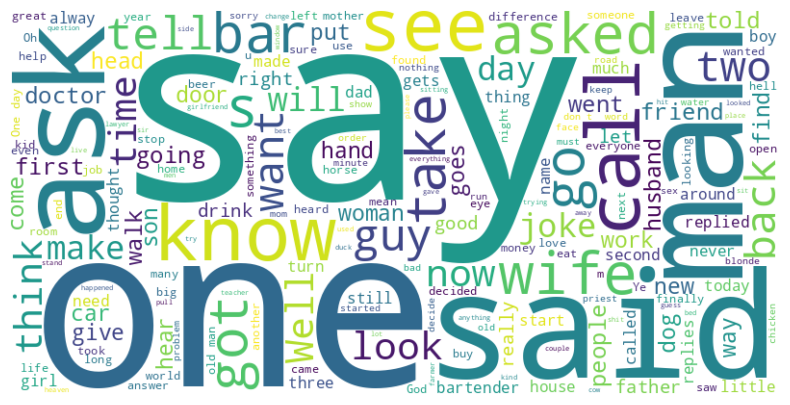

In [12]:
# word cloud for funny jokes
funny_jokes = " ".join(df[df["humor"] == 1]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(funny_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

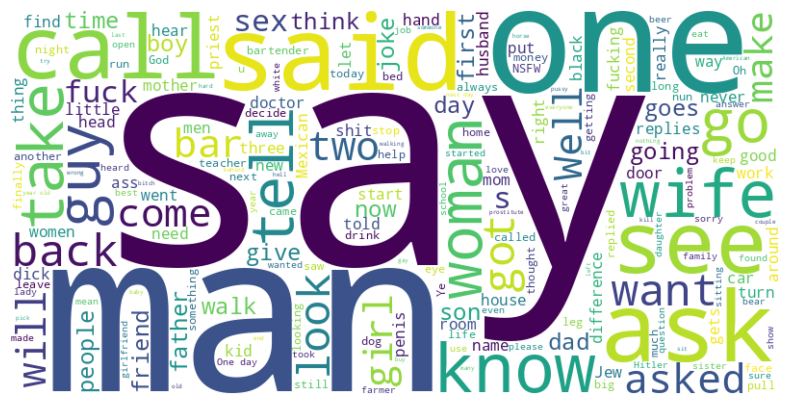

In [13]:
# word cloud for offensive jokes
off_jokes = " ".join(df[df["offensiveness"] == 1]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(off_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

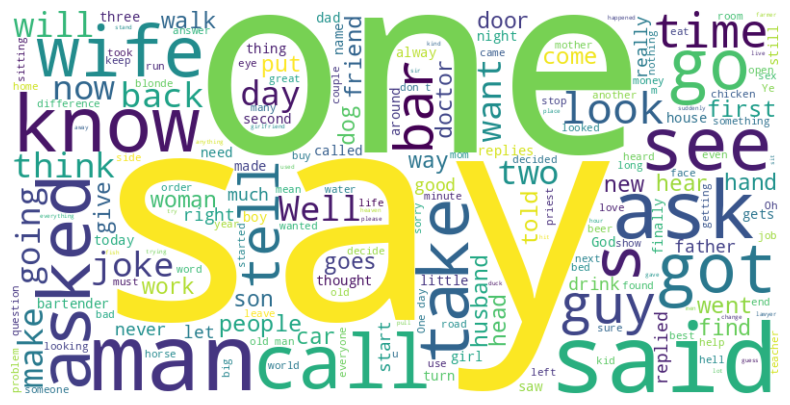

In [14]:
# word cloud for positive jokes
pos_jokes = " ".join(df[df["sentiment"] == 1]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(pos_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

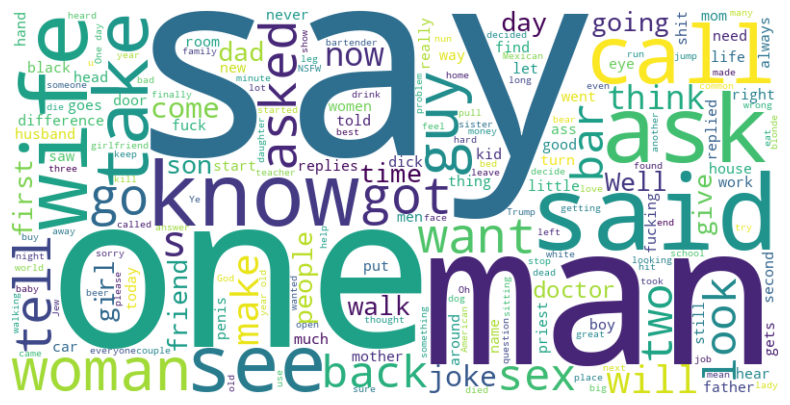

In [15]:
# word cloud for positive jokes
neg_jokes = " ".join(df[df["sentiment"] == 0]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(neg_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
# checking samples
df[df["humor"] == 1]["joke"].iloc[6]

'A drunk man walks out of a bar. A drunk man walks out of a bar and is trying to walk home. As he waddles side to side and back and forth he finally reaches the corner of the street. He then notices something mushy on the sidewalk. The drunk man begins to examine it.   He first grabs a bit with two fingers and starts spreading it on his arms and face. "Well it\'s not lotion" says the the drunk man.   He grabs a handful and starts spreading it in his hair. "Hmmm... it\'s not hair gel either" says the now confused drunk man.   He grabs the remaining pile of mush and smells it. The drunk man screams "Oh damn it\'s SHIT!! Thank God I didn\'t step on it!".'

In [17]:
df[df["offensiveness"] == 1].iloc[4]

date                                              2018-02-20 06:33:41
joke                Old woman in her 60s “An old woman in her 60’s...
score                                                             3.0
humor                                                               0
offensiveness                                                       1
sentiment                                                           0
joke_token_count                                                  144
year                                                           2018.0
Name: 23, dtype: object

In [18]:
df[(df["offensiveness"] == 1) & (df['humor'] == 1)]["joke"].iloc[1]

'THE LION ,THE RABBIT AND THE GENIE Once there was a lion. He saw a rabbit and decided to attack it. The rabbit was running for his life . When suddenly the lion and the rabbit saw a GENIE (like the one from ALADDIN).  GENIE : why are you guys fighting ?  LION  : IM HUNGRY GENIE : I will give you three wishes each , if you stop fighting. LION AND RABBIT : Okay LION : I want food forever RABBIT : I want a helmet GENIE : okay LION : I want all the lions dead because i want the lionesses in my area. RABBIT : I want a motorbike. GENIE : Okay  LION : *LAUGHS* I want all lions dead in the world so i can have the lionesses.  GENIE : okay  *The rabbits looks at the lion * *starts his bike* *slowly starts to drives off and shouts his last wish*  RABBIT : My last wish is you cut the lions dick off ........   '

# conditional probablities

In [19]:
import pandas as pd

# Ensure your DataFrame df has binary columns: humor, offensiveness, sentiment

def conditional_prob(df, A, B):
    # P(A=1 | B=1)
    subset = df[df[B] == 1]
    return subset[A].mean()

labels = ['humor', 'offensiveness', 'sentiment']
results = {}

for a in labels:
    for b in labels:
        if a != b:
            key = f"P({a}=1 | {b}=1)"
            results[key] = conditional_prob(df, a, b)

# Display results
for k, v in results.items():
    print(f"{k}: {v:.2f}")


P(humor=1 | offensiveness=1): 0.01
P(humor=1 | sentiment=1): 0.97
P(offensiveness=1 | humor=1): 0.00
P(offensiveness=1 | sentiment=1): 0.00
P(sentiment=1 | humor=1): 0.91
P(sentiment=1 | offensiveness=1): 0.00


# venn-diagram

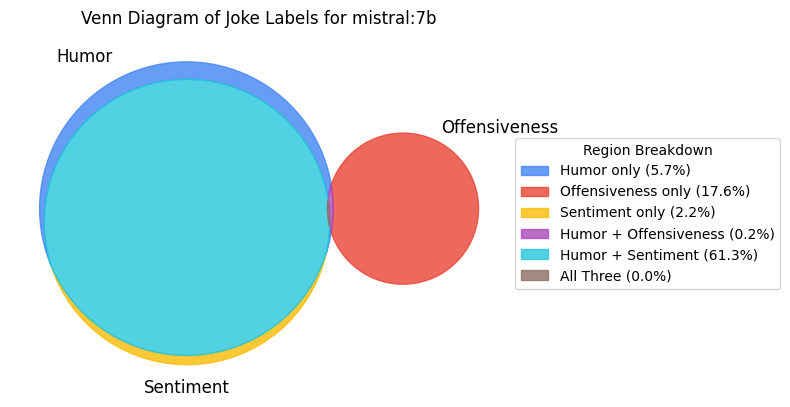

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch

# --- Step 0: Load your dataset ---
# Make sure df has binary columns: 'humor', 'offensiveness', 'sentiment'
# df = pd.read_csv("your_data.csv")

# --- Step 1: Create binary masks ---
total = len(df)
A = df['humor'] == 1
B = df['offensiveness'] == 1
C = df['sentiment'] == 1

# --- Step 2: Compute region counts ---
sets = {
    '100': ((A) & (~B) & (~C)).sum(),
    '010': ((~A) & (B) & (~C)).sum(),
    '001': ((~A) & (~B) & (C)).sum(),
    '110': ((A) & (B) & (~C)).sum(),
    '101': ((A) & (~B) & (C)).sum(),
    '011': ((~A) & (B) & (C)).sum(),
    '111': ((A) & (B) & (C)).sum()
}

# Fill missing regions with 0
for key in ['100', '010', '001', '110', '101', '011', '111']:
    sets.setdefault(key, 0)

# --- Step 3: Convert to percentages ---
percent_labels = {k: f"{v / total * 100:.1f}%" for k, v in sets.items()}

# --- Step 4: Plot Venn with Google Material Design colors ---
plt.figure(figsize=(8, 6))
venn = venn3(subsets=sets, set_labels=('Humor', 'Offensiveness', 'Sentiment'))

# Custom color mapping (only visible if region exists)
color_map = {
    '100': '#4285F4',  # Blue
    '010': '#EA4335',  # Red
    '001': '#FBBC05',  # Yellow
    '110': '#AB47BC',  # Purple
    '101': '#26C6DA',  # Teal
    '011': '#FF7043',  # Orange
    '111': '#8D6E63'   # Brown
}

# Apply custom colors to each patch if it exists
for region_id, color in color_map.items():
    patch = venn.get_patch_by_id(region_id)
    if patch:
        patch.set_color(color)
        patch.set_alpha(0.8)

# Remove text inside diagram
for subset in sets:
    label_obj = venn.get_label_by_id(subset)
    if label_obj:
        label_obj.set_text("")

# --- Step 5: Legend with labels + percentages ---
labels_map = {
    '100': 'Humor only',
    '010': 'Offensiveness only',
    '001': 'Sentiment only',
    '110': 'Humor + Offensiveness',
    '101': 'Humor + Sentiment',
    '011': 'Offensiveness + Sentiment',
    '111': 'All Three'
}

legend_patches = []
for region_id, label_text in labels_map.items():
    patch = venn.get_patch_by_id(region_id)
    if patch:
        color = patch.get_facecolor()
        label = f"{label_text} ({percent_labels[region_id]})"
        legend_patches.append(Patch(color=color, label=label))

plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), title="Region Breakdown")

# --- Step 6: Final touches ---
plt.title("Venn Diagram of Joke Labels for mistral:7b")
plt.tight_layout()

# Optional: Save image
# plt.savefig("venn_diagram_google.png", dpi=300, bbox_inches='tight')

plt.show()
